In [1]:
import logging

import pickle
import torch.nn.functional as F

import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from torch.distributions import constraints
from torch import nn
import pyro
import pyro.distributions as dist
import pyro.optim as optim
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from pyro.infer import Predictive
import seaborn as sns
from pyro import poutine
from sklearn import metrics
from pyro.infer.autoguide import AutoMultivariateNormal, AutoLowRankMultivariateNormal, init_to_mean,init_to_feasible,AutoNormal

In [3]:
with open('VA.pickle', 'rb') as handle:
    data2 = pickle.load(handle)
print(data2.shape)

(5237, 100)


In [32]:
def mix_weights(beta):
    beta1m_cumprod = (1 - beta).cumprod(-1)
    return F.pad(beta, (0, 1), value=1) * F.pad(beta1m_cumprod, (1, 0), value=1)
def model2(data, T, alpha):
    with pyro.plate("beta_plate", T-1):
        beta = pyro.sample("beta", dist.Beta(1,alpha))

    with pyro.plate("mu_plate", T):
        mu = pyro.sample("mu", dist.MultivariateNormal(torch.zeros(100), 1 * torch.eye(100)))
        #cov = pyro.sample("cov", dist.Gamma(torch.ones(1), 2*torch.ones(1)).expand([100]).to_event(1) )

    #cov_matrix = torch.ones(T,100,100)
    #for i in range(0,T):
       # cov_matrix[i] = cov[i]*torch.eye(100)

    with pyro.plate("data", N):
     
        z = pyro.sample("z", dist.Categorical(mix_weights(beta)))
        pyro.sample("obs", dist.MultivariateNormal(mu[z],torch.eye(100)) ,obs=data)#cov_matrix[z]), obs=data)

def guide2(data, T , alpha):
    kappa = pyro.param('kappa', lambda: dist.Uniform(0, 2).sample([T-1]), constraint=constraints.positive)
    tau = pyro.param('tau', lambda: dist.MultivariateNormal(torch.zeros(100), 1 * torch.eye(100)).sample([T]))
    phi = pyro.param('phi', lambda: dist.Dirichlet(1/T * torch.ones(T)).sample([N]), constraint=constraints.simplex)
    #d_alpha = pyro.param('d_alpha', torch.ones(T,100), constraint=constraints.positive)#*self.user_mean)
    #d_beta = pyro.param('d_beta', =torch.ones(T,100), constraint=constraints.positive)

    with pyro.plate("beta_plate", T-1):
        q_beta = pyro.sample("beta", dist.Beta(torch.ones(T-1), kappa))

    with pyro.plate("mu_plate", T):
        q_mu = pyro.sample("mu", dist.MultivariateNormal(tau, torch.eye(100)))
        #cov = pyro.sample("cov", dist.Gamma(d_alpha, d_beta).to_event(1))

    with pyro.plate("data", N):
        z = pyro.sample("z", dist.Categorical(phi))

def train2(num_iterations, trainin, T_final, alpha):
    pyro.clear_param_store()
    optimize = optim.ClippedAdam({"lr": 0.05, "lrd": 1})
    svi = SVI(model2, guide2, optimize, loss=Trace_ELBO())
    losses = []
    for j in range(num_iterations):
        loss = svi.step(trainin, T_final, alpha)
        losses.append(loss)
        if j % 10 == 0:
                        print("Elbo loss: {}".format(loss))
    return losses

def truncate(alpha, centers, weights):
    threshold = alpha**-1 / 100.
    true_centers = centers[weights > threshold]
    true_weights = weights[weights > threshold] / torch.sum(weights[weights > threshold])
    return true_centers, true_weights

def data_prep(data):
    df = pd.DataFrame(data)
    df_test = df.sample(frac=0.1)
    data_train = torch.tensor(df.drop(df_test.index).values, dtype=torch.float)
    data_test = torch.tensor(df_test.values, dtype=torch.float) 
    return data_train, data_test

def pred_likel(data_train,data_test):
    N = data_train.shape[0]
    N_test = data_test.shape[0]
    alpha = 1.5
    #train2(1000, data_train, 150,alpha)
    Bayes_Centers_01, Bayes_Weights_01 = truncate(alpha, pyro.param("tau").detach(), torch.mean(pyro.param("phi").detach(), dim=0))
    #T_final=Bayes_Centers_01.shape[0]
    alphas = [4]
    log_predictives = []

    for val in alphas:
        alpha = val
        T = 73#
        T_final =73
        train2(700, data_train, T_final, alpha)

        S = 200 # number of Monte Carlo samples to use in posterior predictive computations

        # Using pyro's built in posterior predictive class:
        posterior = Predictive(guide2, num_samples=S, return_sites=["beta", "mu"])(data_train , T, val)
        post_pred_weights = mix_weights(posterior["beta"])
        post_pred_clusters = posterior["mu"]
        log_prob = (post_pred_weights.log() + dist.MultivariateNormal(post_pred_clusters, torch.eye(100)).log_prob(data_test.reshape(-1, 1, 1,100))).logsumexp(-1)
        mean_log_prob = log_prob.logsumexp(-1) - np.log(S)
        log_posterior_predictive = mean_log_prob.sum(-1)
        log_predictives.append(log_posterior_predictive)
        print(log_posterior_predictive)
    return log_predictives , T_final

    
    



In [40]:
with open('UA.pickle', 'rb') as handle:
     data2 = pickle.load(handle)
trainin,test = data_prep(data2)

N=trainin.shape[0]







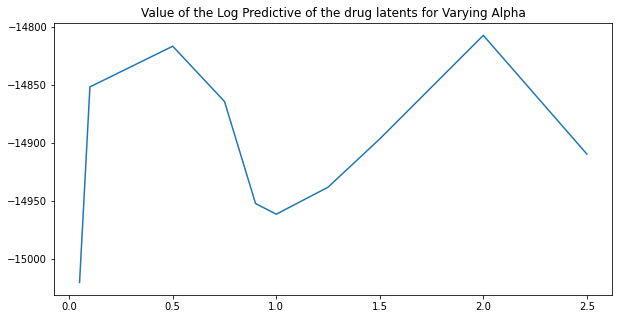

In [55]:
plt.figure(figsize=(10, 5))

plt.plot([0.05, 0.1, 0.5, 0.75, 0.9, 1., 1.25, 1.5, 2, 2.5], lp[0])
plt.title("Value of the Log Predictive of the drug latents for Varying Alpha")
plt.savefig("log_pred_drug_all_opt.png")
plt.show()

In [42]:
pyro.set_rng_seed(80)
N = data2.shape[0]
final_parameters =  train2(500, torch.tensor(data2), 73, 0.75)

Elbo loss: 241136.979347229
Elbo loss: 212599.3376493454
Elbo loss: 196136.18248653412
Elbo loss: 186528.1527786255
Elbo loss: 181471.61784362793
Elbo loss: 178632.40148973465
Elbo loss: 176976.0152850151
Elbo loss: 176553.71593379974
Elbo loss: 176439.2492930889
Elbo loss: 177913.80118083954
Elbo loss: 175714.87017726898
Elbo loss: 174496.02081394196
Elbo loss: 173417.78718566895
Elbo loss: 172520.69974422455
Elbo loss: 171285.67141151428
Elbo loss: 172972.92757225037
Elbo loss: 173699.00487804413
Elbo loss: 169917.19396018982
Elbo loss: 169922.78885650635
Elbo loss: 168457.7924003601
Elbo loss: 170227.15161895752
Elbo loss: 169695.51713752747
Elbo loss: 168862.30360031128
Elbo loss: 169276.50129699707
Elbo loss: 169193.87407302856
Elbo loss: 169266.0311050415
Elbo loss: 170844.40491867065
Elbo loss: 168694.87403678894
Elbo loss: 170088.90476417542
Elbo loss: 168609.36100959778
Elbo loss: 169886.47485733032
Elbo loss: 168363.8094959259
Elbo loss: 170680.74842071533
Elbo loss: 169141.5

In [44]:
t=pyro.param("tau").detach()
phi = pyro.param("phi").detach()
print(t.shape)
print(phi.shape)
data_all = t,phi
with open('drug_param.pickle', 'wb') as handle:
    pickle.dump(data_all, handle, protocol=pickle.HIGHEST_PROTOCOL)
print(t)


torch.Size([73, 100])
torch.Size([1127, 73])
tensor([[ 0.1357,  0.1268,  0.0492,  ...,  0.2582, -0.0935, -0.0015],
        [ 0.0675,  0.1032,  0.0752,  ..., -0.1219, -0.1378, -0.0188],
        [-0.1758,  0.1321, -0.2739,  ...,  0.1403, -0.0296, -0.0581],
        ...,
        [ 0.1055,  0.0107,  0.1632,  ..., -0.0275,  0.0028,  0.1868],
        [ 0.0715,  0.1371, -0.3476,  ..., -0.1025,  0.2030, -0.1155],
        [-0.0029,  0.1162, -0.1286,  ...,  0.4203, -0.1620,  0.3699]])
